In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gc

# Limpieza memoria
tf.keras.backend.clear_session()
gc.collect()

# --- TU CONFIGURACIÓN DE GPU ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU Detectada y Configurada: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No se detectó GPU. Se usará CPU.")


I0000 00:00:1766045235.319182     501 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1766045235.918396     501 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1766045237.617702     501 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✅ GPU Detectada y Configurada: /physical_device:GPU:0


W0000 00:00:1766045238.486229     501 cuda_executor.cc:1839] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1766045238.872774     501 cuda_executor.cc:1839] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1766045238.873088     501 cuda_executor.cc:1839] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1766045238.873102     501 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [2]:
imgpath = "./dataset" # Ruta relativa para WSL
images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            
            # Lectura original (Asumiendo que ya son 100x100 o se redimensionan externamente)
            # Si necesitas redimensionar aqui, avísame, pero dejé el original plt.imread
            image = plt.imread(filepath)
            
            # Aseguramos 3 canales por si hay algun blanco y negro
            if len(image.shape) == 2:
                 image = np.stack((image,)*3, axis=-1)
                 
            images.append(image)
            
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))


leyendo imagenes de  ./dataset
./dataset/tortugas 1
./dataset/perros 10860
./dataset/gato 10768
./dataset/hormigas 10528
./dataset/mariquitas 10008
Directorios leidos: 5
Imagenes en cada directorio [10861, 10768, 10528, 10008, 10559]
suma Total de imagenes en subdirs: 52724


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

animales=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    animales.append(name[len(name)-1])
    indice=indice+1

y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Cantidad etiquetas creadas:  52724
0 tortugas
1 perros
2 gato
3 hormigas
4 mariquitas
Total number of outputs :  5
Output classes :  [0 1 2 3 4]


Training data shape :  (42179, 100, 100, 3) (42179,)
Testing data shape :  (10545, 100, 100, 3) (10545,)
Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0.]
(33743, 100, 100, 3) (8436, 100, 100, 3) (33743, 5) (8436, 5)


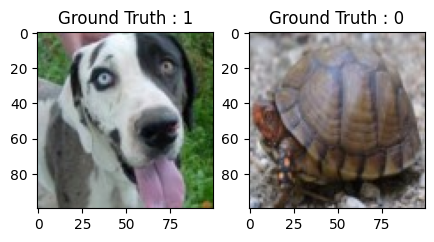

In [4]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)


In [ ]:
INIT_LR = 1e-2 # Valor inicial de learning rate
epochs = 100 
batch_size = 64 

animal_model = Sequential()
# Bloque 1 (Input Shape ajustado a 100x100)
animal_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(100,100,3)))
animal_model.add(LeakyReLU(alpha=0.1))
animal_model.add(BatchNormalization())
animal_model.add(MaxPooling2D(pool_size=(2, 2)))
animal_model.add(Dropout(0.25))

# Bloque 2
animal_model.add(Conv2D(64, kernel_size=(3, 3), activation='linear', padding='same'))
animal_model.add(LeakyReLU(alpha=0.1))
animal_model.add(BatchNormalization())
animal_model.add(MaxPooling2D(pool_size=(2, 2)))
animal_model.add(Dropout(0.25))


# Clasificación final
animal_model.add(Flatten())
animal_model.add(Dense(64, activation='linear'))
animal_model.add(LeakyReLU(alpha=0.1))
animal_model.add(Dropout(0.5))
animal_model.add(Dense(nClasses, activation='softmax'))

animal_model.summary()

animal_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR),
    metrics=['accuracy']
)


/home/luisma/miniconda3/envs/proenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1766045268.947752     501 cuda_executor.cc:1839] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1766045268.948790     501 cuda_executor.cc:1839] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1766045268.949096     501 cuda_executor.cc:1839] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1766045268.949112     501 gpu_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,181 (4.86 MB)

 Trainable params: 1,273,733 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
early_stop=EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
checkpoint= ModelCheckpoint('best_animal_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

animal_train = animal_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label), 
                             callbacks=[early_stop, reduce_lr, checkpoint])

animal_model.save("animales_mnist_100x100.keras")


Epoch 1/100


I0000 00:00:1766045299.212802     593 service.cc:153] XLA service 0x7b53e8036350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766045299.212844     593 service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1766045299.313981     593 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766045299.534235     593 cuda_dnn.cc:462] Loaded cuDNN version 91002
I0000 00:00:1766045300.263975     664 subprocess_compilation.cc:347] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_10', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1766045300.300320     660 subprocess_compilation.cc:347] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_1_6', 4 bytes spill stores, 4 bytes spill loads



 11/528 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2661 - loss: 6.0478

I0000 00:00:1766045305.425129     593 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5251 - loss: 1.6449
Epoch 1: val_loss improved from None to 1.41917, saving model to best_animal_model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6047 - loss: 1.1329 - val_accuracy: 0.5562 - val_loss: 1.4192 - learning_rate: 0.0100
Epoch 2/100
527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7147 - loss: 0.7524
Epoch 2: val_loss improved from 1.41917 to 0.73681, saving model to best_animal_model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7378 - loss: 0.6998 - val_accuracy: 0.7546 - val_loss: 0.7368 - learning_rate: 0.0100
Epoch 3/100
525/528 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7893 - loss: 0.5782
Epoch 3: val_loss improved from 0.73681 to 0.50532, saving model to best_animal_model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7909 - loss: 0.5689 - val_accuracy: 0.8244 - val_loss: 0.5053 - learning_rate: 0.0100
Epoch 4/100
526/528 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8989 - loss: 0.3339
Test loss: 0.3338693380355835
Test accuracy: 0.8989094495773315


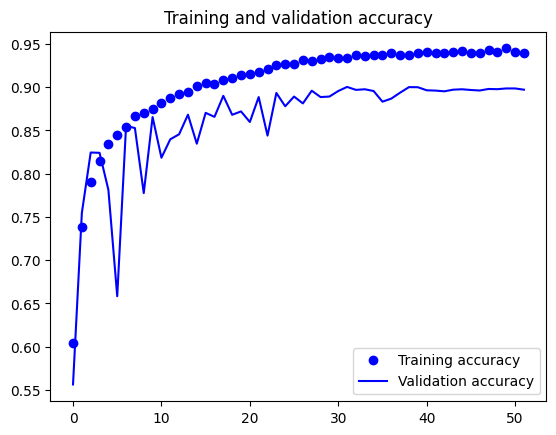

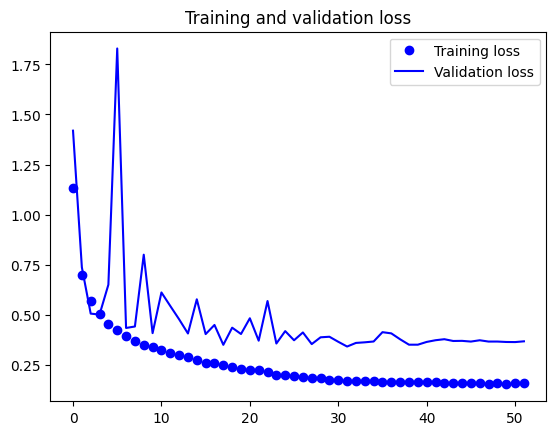

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Found 9479 correct labels
Found 1066 incorrect labels
              precision    recall  f1-score   support

     Class 0       0.88      0.96      0.92      2133
     Class 1       0.88      0.81      0.84      2173
     Class 2       0.82      0.86      0.84      2085
     Class 3       0.94      0.92      0.93      2030
     Class 4       0.98      0.95      0.97      2124

    accuracy                           0.90     10545
   macro avg       0.90      0.90      0.90     10545
weighted avg       0.90      0.90      0.90     10545



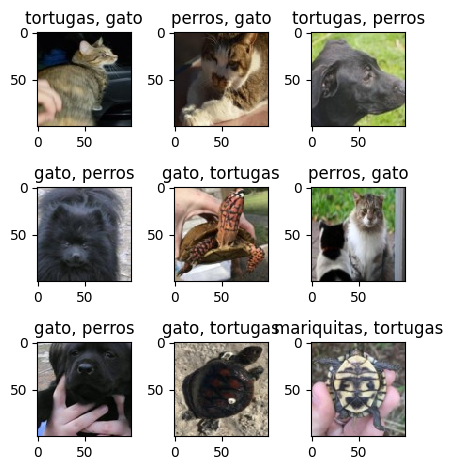

In [7]:
test_eval = animal_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = animal_train.history['accuracy']
val_accuracy = animal_train.history['val_accuracy']
loss = animal_train.history['loss']
val_loss = animal_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# PREDICCIONES Y MATRIZ (Lógica Original)
predicted_classes2 = animal_model.predict(test_X)
predicted_classes=[]
for predicted_animal in predicted_classes2:
    predicted_classes.append(predicted_animal.tolist().index(max(predicted_animal)))
predicted_classes=np.array(predicted_classes)

correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(100,100,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(animales[predicted_classes[correct]],
                                                    animales[test_Y[correct]]))
    plt.tight_layout()

incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(100,100,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(animales[predicted_classes[incorrect]],
                                                    animales[test_Y[incorrect]]))
    plt.tight_layout()

target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))


Cargando modelo...
✅ Se encontraron 5 imágenes. Procesando...

Resultados:
--------------------------------------------------
images (1).jpg       -> perros     (100.00%)
images.jpg           -> perros     (99.98%)
perro01.jpg          -> perros     (99.99%)
perro02.jpg          -> perros     (100.00%)
perro03.jpg          -> perros     (99.97%)


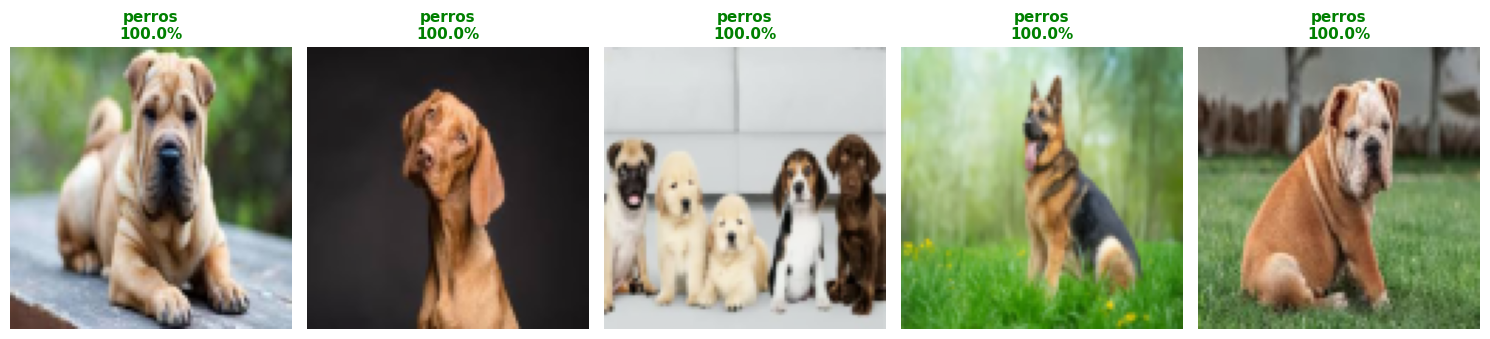

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import load_model
import os
import math

print("Cargando modelo...")
animal_model = load_model("./best_model.keras")

animales = [
    "hormigas",  # 0
    "gato",        # 1
    "perros",      # 2
    "mariquitas",    # 3
    "tortugas"     # 4
]


carpeta_imagenes = 'perros'
extensiones_validas = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')

filenames = []

if os.path.exists(carpeta_imagenes):
    for archivo in os.listdir(carpeta_imagenes):
        if archivo.lower().endswith(extensiones_validas):
            filenames.append(os.path.join(carpeta_imagenes, archivo))


if not filenames:
    print(f"❌ No se encontraron imágenes en la carpeta '{carpeta_imagenes}'")
else:
    print(f"✅ Se encontraron {len(filenames)} imágenes. Procesando...")

    images = []
    valid_files = []

    for filepath in filenames:
        try:
            # Leer imagen
            image = plt.imread(filepath)

            # Redimensionar a 100x100 (manteniendo rango 0-255)
            image_resized = resize(
                image,
                (85, 85),
                anti_aliasing=True,
                clip=False,
                preserve_range=True
            )

            # Asegurar 3 canales (RGB)
            if len(image_resized.shape) == 2:
                image_resized = np.stack((image_resized,) * 3, axis=-1)

            # Eliminar canal alfa si existe
            if image_resized.shape[2] == 4:
                image_resized = image_resized[:, :, :3]

            images.append(image_resized)
            valid_files.append(filepath)

        except Exception as e:
            print(f"⚠️ Error al procesar {filepath}: {e}")


    if images:
        X = np.array(images, dtype=np.uint8)
        test_X_ext = X.astype('float32') / 255.0

        predicted_classes = animal_model.predict(test_X_ext, verbose=0)

        # Configuración de la cuadrícula
        num_imgs = len(images)
        cols = 5
        rows = math.ceil(num_imgs / cols)

        plt.figure(figsize=(15, 3.5 * rows))

        print("\nResultados:")
        print("-" * 50)

        for i, pred in enumerate(predicted_classes):
            predicted_index = np.argmax(pred)
            confianza = pred[predicted_index] * 100
            nombre_archivo = os.path.basename(valid_files[i])

            clase_nombre = animales[predicted_index]

            plt.subplot(rows, cols, i + 1)
            plt.imshow(test_X_ext[i])
            plt.axis('off')

            color_texto = 'green' if confianza > 80 else 'black'
            plt.title(
                f"{clase_nombre}\n{confianza:.1f}%",
                color=color_texto,
                fontsize=11,
                fontweight='bold'
            )

            print(f"{nombre_archivo:20} -> {clase_nombre:10} ({confianza:.2f}%)")

        plt.tight_layout()
        plt.show()
